<a href="https://colab.research.google.com/github/Vulter3653/ML/blob/main/Credit_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC_feature_%ED%91%9C%EC%A4%80%ED%99%94_%ED%94%BC%EB%93%9C%EB%B0%B1_%EC%9D%B4%ED%9B%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install catboost -q

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import os
os.chdir('/content/gdrive/My Drive/credit')

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
# 결측치가 존재 ->제거
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

# 모든 값이 동일 -> 제거
train=train.drop('FLAG_MOBIL', axis=1)
test=test.drop('FLAG_MOBIL', axis=1)

train['gender'] = train['gender'].replace(['F', 'M'], [0, 1])
test['gender'] = test['gender'].replace(['F', 'M'], [0, 1])

train['car'] = train['car'].replace(['N', 'Y'], [0, 1])
test['car'] = test['car'].replace(['N', 'Y'], [0, 1])

train['reality'] = train['reality'].replace(['N', 'Y'], [0, 1])
test['reality'] = test['reality'].replace(['N', 'Y'], [0, 1])

# 자식의 숫자가 2보다 큰 경우 합쳐서 처리
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
#######################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
#######################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,0,0,0,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,225000.0,2,4,1,1,-12079,-1984,0,0,0,4.0,-2.0,1.0
26453,26453,0,0,1,1,180000.0,4,1,2,1,-15291,-2475,0,0,0,2.0,-47.0,2.0
26454,26454,0,1,0,0,292500.0,4,4,0,5,-10082,-2015,0,0,0,2.0,-25.0,2.0
26455,26455,1,0,1,0,171000.0,4,2,3,1,-10145,-107,0,0,0,1.0,-59.0,2.0


In [ ]:
def birthday(x):
        return abs(x)//365//10
def jj(x):
        return abs(x)//12
def j(x):
    if x == 365243:
        x = 0
        return (x)
    else:
        return (abs(x)//360//12)+1

In [ ]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(birthday)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(j)
train['begin_month'] = train['begin_month'].apply(jj)

test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(birthday)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(j)
test['begin_month'] = test['begin_month'].apply(jj)

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,202500.0,0,1,1,2,3,2,0,0,0,2.0,0.0,1.0
1,1,0,0,1,1,247500.0,0,4,0,1,3,1,0,0,1,3.0,0.0,1.0
2,2,1,1,1,0,450000.0,4,1,1,1,5,2,0,1,0,2.0,1.0,2.0
3,3,0,0,1,0,202500.0,0,4,1,1,4,1,0,1,0,2.0,3.0,0.0
4,4,0,1,1,0,157500.0,2,1,1,1,4,1,0,0,0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,225000.0,2,4,1,1,3,1,0,0,0,4.0,0.0,1.0
26453,26453,0,0,1,1,180000.0,4,1,2,1,4,1,0,0,0,2.0,3.0,2.0
26454,26454,0,1,0,0,292500.0,4,4,0,5,2,1,0,0,0,2.0,2.0,2.0
26455,26455,1,0,1,0,171000.0,4,2,3,1,2,1,0,0,0,1.0,4.0,2.0


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,112500.0,1,4,0,1,6,0,0,1,0,2.0,5.0
1,26458,0,0,1,0,135000.0,2,1,1,1,5,3,0,1,0,2.0,3.0
2,26459,0,0,1,0,69372.0,4,4,1,1,4,1,1,1,0,2.0,3.0
3,26460,1,1,0,0,112500.0,0,4,1,1,5,1,1,0,0,2.0,3.0
4,26461,0,1,1,0,225000.0,2,1,1,1,4,3,1,0,0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,202500.0,4,2,1,1,5,2,1,1,0,2.0,1.0
9996,36453,1,1,1,0,202500.0,4,4,0,1,2,1,1,0,0,2.0,2.0
9997,36454,0,0,1,0,292500.0,4,4,1,1,5,4,0,0,0,2.0,4.0
9998,36455,0,1,0,0,180000.0,0,4,1,1,4,1,0,1,0,2.0,2.0


AxesSubplot(0.125,0.125;0.775x0.755)


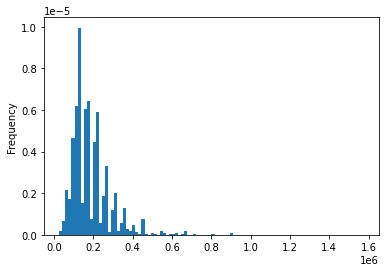

In [ ]:
print(train['income_total'].plot(kind='hist',bins=100,density=True))

In [ ]:
# feature 표준화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 평균 0, 표준편차 1
scale_columns = ['income_total']
train[scale_columns] = scaler.fit_transform(train[scale_columns])
test[scale_columns] = scaler.fit_transform(test[scale_columns])

AxesSubplot(0.125,0.125;0.775x0.755)


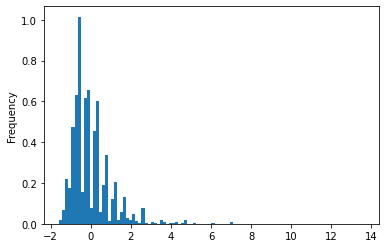

In [ ]:
print(train['income_total'].plot(kind='hist',bins=100,density=True))

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0.149136,0,1,1,2,3,2,0,0,0,2.0,0.0,1.0
1,1,0,0,1,1,0.590848,0,4,0,1,3,1,0,0,1,3.0,0.0,1.0
2,2,1,1,1,0,2.578550,4,1,1,1,5,2,0,1,0,2.0,1.0,2.0
3,3,0,0,1,0,0.149136,0,4,1,1,4,1,0,1,0,2.0,3.0,0.0
4,4,0,1,1,0,-0.292575,2,1,1,1,4,1,0,0,0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0.369992,2,4,1,1,3,1,0,0,0,4.0,0.0,1.0
26453,26453,0,0,1,1,-0.071719,4,1,2,1,4,1,0,0,0,2.0,3.0,2.0
26454,26454,0,1,0,0,1.032559,4,4,0,5,2,1,0,0,0,2.0,2.0,2.0
26455,26455,1,0,1,0,-0.160062,4,2,3,1,2,1,0,0,0,1.0,4.0,2.0


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,-0.714468,1,4,0,1,6,0,0,1,0,2.0,5.0
1,26458,0,0,1,0,-0.492869,2,1,1,1,5,3,0,1,0,2.0,3.0
2,26459,0,0,1,0,-1.139229,4,4,1,1,4,1,1,1,0,2.0,3.0
3,26460,1,1,0,0,-0.714468,0,4,1,1,5,1,1,0,0,2.0,3.0
4,26461,0,1,1,0,0.393527,2,1,1,1,4,3,1,0,0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0.171928,4,2,1,1,5,2,1,1,0,2.0,1.0
9996,36453,1,1,1,0,0.171928,4,4,0,1,2,1,1,0,0,2.0,2.0
9997,36454,0,0,1,0,1.058325,4,4,1,1,5,4,0,0,0,2.0,4.0
9998,36455,0,1,0,0,-0.049671,0,4,1,1,4,1,0,1,0,2.0,2.0


In [ ]:
train.to_csv('train3.csv',index=False)
test.to_csv('test3.csv',index=False)